# Notebook 2: Model Selection

**Haley Lautenbach**<br>
haley.lautenbach@gmail.com

**Research Problem:**
There are many movie recommendation systems or streaming services that allow for users to set up a profile. This profile then adds information to the system about what types of films the user does and doesn't like, allowing for the system to make personalized recommendations to the user. However, there doesn't seem to be systems that recommend to more than one user, allowing for couples, families, groups of friends, to have personalized recommendations that take all of their preferences into account. 

This notebook is 2/4. It will first cover the creation of the movie similarities dataset, which uses cosine similarity and our previously created movie-feature utility matrix to judge which movies are most similar to eachother. This similarities dataset will eventually be used for choosing movies similar to the predicted top choices for our users, giving a more wide breadth of recommended options. The notebook will then cover the selection and optimzation of models for predicting user ratings. The models tested below are the Simon Funk SVD (Single Value Decomposition) as well as KNNBaseline, which is a KNN style type of recommender. 

In [3]:
# for visualizations & dataframe manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for pre-processing & evaluation
import random
from surprise import Dataset
from surprise.reader import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

# for modelling
from sklearn.metrics.pairwise import cosine_similarity
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms import KNNBaseline
from surprise.model_selection import GridSearchCV

# to save models
from surprise import dump

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-2:-Model-Selection" data-toc-modified-id="Notebook-2:-Model-Selection-1">Notebook 2: Model Selection</a></span><ul class="toc-item"><li><span><a href="#1.1-Reading-in-Reference-Table" data-toc-modified-id="1.1-Reading-in-Reference-Table-1.1">1.1 Reading in Reference Table</a></span></li><li><span><a href="#1.2-Reading-in-Feature-Utility-Matrix" data-toc-modified-id="1.2-Reading-in-Feature-Utility-Matrix-1.2">1.2 Reading in Feature Utility Matrix</a></span></li><li><span><a href="#1.3-Creation-of-User-Utility-Matrix" data-toc-modified-id="1.3-Creation-of-User-Utility-Matrix-1.3">1.3 Creation of User Utility Matrix</a></span></li></ul></li><li><span><a href="#2.-Cosine-Similarity:-Item-Item-Content-Filtering" data-toc-modified-id="2.-Cosine-Similarity:-Item-Item-Content-Filtering-2">2. Cosine Similarity: Item-Item Content Filtering</a></span></li><li><span><a href="#3.-FunkSVD" data-toc-modified-id="3.-FunkSVD-3">3. FunkSVD</a></span><ul class="toc-item"><li><span><a href="#3.1-Initial-Check-for-Ideal-Number-of-Factors" data-toc-modified-id="3.1-Initial-Check-for-Ideal-Number-of-Factors-3.1">3.1 Initial Check for Ideal Number of Factors</a></span></li><li><span><a href="#3.2-Grid-Search-for-Hyperparameter-Optimization" data-toc-modified-id="3.2-Grid-Search-for-Hyperparameter-Optimization-3.2">3.2 Grid Search for Hyperparameter Optimization</a></span><ul class="toc-item"><li><span><a href="#3.2.1-Grid-Search-1" data-toc-modified-id="3.2.1-Grid-Search-1-3.2.1">3.2.1 Grid Search 1</a></span></li><li><span><a href="#3.2.2-Grid-Search-2" data-toc-modified-id="3.2.2-Grid-Search-2-3.2.2">3.2.2 Grid Search 2</a></span></li><li><span><a href="#3.2.3-Grid-Search-3" data-toc-modified-id="3.2.3-Grid-Search-3-3.2.3">3.2.3 Grid Search 3</a></span></li><li><span><a href="#3.2.4-Grid-Search-4" data-toc-modified-id="3.2.4-Grid-Search-4-3.2.4">3.2.4 Grid Search 4</a></span></li><li><span><a href="#3.2.5-Grid-Search-5" data-toc-modified-id="3.2.5-Grid-Search-5-3.2.5">3.2.5 Grid Search 5</a></span></li></ul></li><li><span><a href="#3.3-Visualization-of-Scores-at-Best-Parameters" data-toc-modified-id="3.3-Visualization-of-Scores-at-Best-Parameters-3.3">3.3 Visualization of Scores at Best Parameters</a></span></li><li><span><a href="#3.4-Retraining-Best-SVD-on-Full-Trainset" data-toc-modified-id="3.4-Retraining-Best-SVD-on-Full-Trainset-3.4">3.4 Retraining Best SVD on Full Trainset</a></span></li><li><span><a href="#3.5-Visualization-of-Latent-Variables" data-toc-modified-id="3.5-Visualization-of-Latent-Variables-3.5">3.5 Visualization of Latent Variables</a></span></li></ul></li><li><span><a href="#4.-KNNBaseline" data-toc-modified-id="4.-KNNBaseline-4">4. KNNBaseline</a></span><ul class="toc-item"><li><span><a href="#4.1-Number-of-Neighbours-Optimization" data-toc-modified-id="4.1-Number-of-Neighbours-Optimization-4.1">4.1 Number of Neighbours Optimization</a></span></li><li><span><a href="#4.2-Visualization-of-Scores-for-Number-of-Neighbours" data-toc-modified-id="4.2-Visualization-of-Scores-for-Number-of-Neighbours-4.2">4.2 Visualization of Scores for Number of Neighbours</a></span></li><li><span><a href="#4.3-Retraining-Best-KNN-on-Full-Trainset" data-toc-modified-id="4.3-Retraining-Best-KNN-on-Full-Trainset-4.3">4.3 Retraining Best KNN on Full Trainset</a></span></li></ul></li></ul></div>

## 1.1 Reading in Reference Table

In [82]:
movies_reference = pd.read_csv('My Datasets/movies_reference.csv')
movies_reference

,movieId,title,year_of_release,averageRating,numVotes,runtimeMinutes
0,1,Toy Story,1995,8.3,896826.0,81.0
1,2,Jumanji,1995,7.0,312103.0,104.0
2,3,Grumpier Old Men,1995,6.7,24447.0,101.0
3,4,Waiting to Exhale,1995,6.0,9671.0,124.0
4,5,Father of the Bride Part II,1995,6.1,34885.0,106.0
...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben,2007,5.0,1409.0,85.0
27274,131256,"Feuer, Eis & Dosenbier",2002,3.3,1077.0,83.0
27275,131258,The Pirates,2014,6.6,2957.0,130.0
27276,131260,Rentun Ruusu,2001,6.6,1221.0,102.0


In [83]:
movies_reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movieId          27278 non-null  int64  
 1   title            27278 non-null  object 
 2   year_of_release  27278 non-null  int64  
 3   averageRating    27278 non-null  float64
 4   numVotes         27278 non-null  float64
 5   runtimeMinutes   27278 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.2+ MB


## 1.2 Reading in Feature Utility Matrix

In [84]:
movies_utility = pd.read_csv('My Datasets/movies_utility.csv', index_col=0)

In [38]:
movies_utility.head()

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Tito Carpi,Bob Kane,Kuang Ni,Dardano Sacchetti,Jack Kirby,Stan Lee,movie,short_y,tvMovie,video
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


It looks like there is still a column called "movie" in the utility matrix, we will be dropping this column. It also seems as though, post-merge, there are two columns denoted as "short". We will be dropping the original "short_x", which most likely came from the tags, and keeping the secondary "short_y". We want the column that came from the IMDB labels, because it denotes a title type of short films. The one that came from the tags is user generated and may also apply to films that are short according to the user, but not necessarily an actual short film. We will also be dropping the movieId, so that the IDs do not affect the results when we apply cosine similarity to the matrix.

In [85]:
# dropping the movie column, the movieId column & the short_x column
columns_to_drop_mu = ['movie', 'short_x', 'movieId']
movies_utility.drop(columns=columns_to_drop_mu, inplace=True)
movies_utility.rename(columns={'short_y':'short'}, inplace=True)

In [86]:
movies_utility.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Mario Amendola,Tito Carpi,Bob Kane,Kuang Ni,Dardano Sacchetti,Jack Kirby,Stan Lee,short,tvMovie,video
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.3 Creation of User Utility Matrix

For the creation of the user utility matrix, we first have to read in the ratings data from [MovieLens](https://grouplens.org/datasets/movielens/1m/). We will be using the MovieLens 1M dataset so that the models can be optimized on our local machine. The surprise package has methods to create surprise "datasets", which are the preferred format for the many models within the package.

In [4]:
ratings_df = pd.read_csv('Datasets/ml-1m/ratings.dat', sep="::", engine='python', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

In [5]:
ratings_df['rating'].unique()

array([5, 3, 4, 2, 1])

In [6]:
ratings_df.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


The ratings scale runs from 1-5, with no floats or null values so there is no rounding or datatype changes to be made at this point.

**Columns in the ratings dataset:**
- `userId`: the indiviudal ids for each user, integer.
- `movieId`: the individual ids for each movie, integer.
- `rating`: the rating that a user assigned to a specific movie, int. The ratings are a whole number between 1 and 5.
- `timestamp`: the time the rating was logged, integer. This timestamp is represented as UNIX time, which is the amount of time in seconds that has elapsed since 00:00:00 UTC January 1, 1970. It is possible to convert this column to regular datetime datatype, which will then allow us to pull out the year/month/day that the rating was logged. This may be helpful for assesing how the ratings change from a movie release date to the rating date, as well as how certain users rate films over time or across seasons.

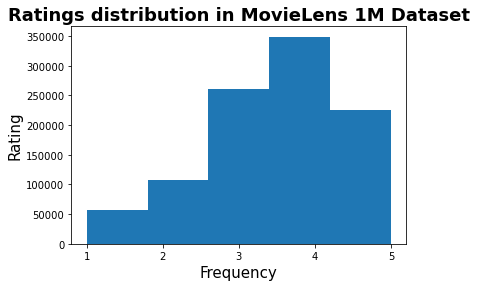

In [14]:
plt.figure()
plt.hist(ratings_df['rating'], bins=5)
plt.title('Ratings distribution in MovieLens 1M Dataset', fontsize=18, fontweight=700)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.xticks(range(1,6))
plt.show()

It looks like the distribution has a slight left-skew, with the majority of ratings over 3. This distribution is not unsurprising, but also not as drastic as some that we've seen. A threshold of 4 would probably be appropriate to weed out unpopular films when we are in the recommending stage.

To create a surprise dataset, the package can be loaded from a dataframe, but it requires a "reader" to interpet the scale. This will be easy enough for us, because the rating scale is a simple 1-5. Once loaded, the surprise dataset can be used to create training and test sets for the models.

In [7]:
reader = Reader(rating_scale=(1,5))

In [8]:
ratings_utility = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader=reader)

In [9]:
ratings_utility

# 2. Cosine Similarity: Item-Item Content Filtering

To recommend movies that are similar to others, like other systems style of "Because you watched...", we need to score movies on how similar they are to each other. We will be choosing the cosine similarity as our metric, which measures how similar to vectors are to each other. It does so by calculating the cosine of the angle between the two vectors, which is why we had to have the movie-feature utility matrix in such a particular format. This format has each row pertain to movie and each column pertain to a particular feature of that movie, allowing for each row to be a non-zero vector that can then be judged against another for levels of similarity.
Cosine similarity is calculated as:


$$\frac{a \cdot b}{||a||\cdot ||b||}$$


Which is the dot product of the two vectors over the length of each vector, multiplied. Thankfully sklearn has a method for this as well, so it is one simple line of code.

In [87]:
# calculate cosine similarity
movie_similarities = cosine_similarity(movies_utility, dense_output=False)

In [88]:
movie_similarities.shape

(27278, 27278)

The output of this method is a matrix of equal rows and columns where each movie can be judged against every other movie in the dataset for level of similarity. To demonstrate, we can find a film to judge whether the feature matrix was properly set up for similarity calculations.
We will be going forward with The Sound of Music. To search movies within the similarities matrix, we must search by their index number, not by their movieId. The reference table has had the index reset to match that of the similarities matrix, so we can search by movie title and use the index number of that row to then search against the similarities matrix.

In [94]:
# searching by keyword in the titles
movies_reference[movies_reference['title'].str.contains("Sound")]

,movieId,title,year_of_release,averageRating,numVotes,runtimeMinutes
1016,1035,"Sound of Music, The",1965,8.0,208930.0,172.0
9287,27334,Sound and Fury,2000,7.9,946.0,80.0
9397,27618,"Sound of Thunder, A",2005,4.3,18926.0,110.0
9696,31413,"White Sound, The (Das weiße Rauschen)",2001,7.1,3159.0,109.0
10473,38473,Touch the Sound: A Sound Journey with Evelyn G...,2004,7.3,591.0,99.0
10630,41226,Sounder,1972,7.6,3692.0,105.0
11084,46098,Crossing the Bridge: The Sound of Istanbul,2005,7.9,6119.0,90.0
12466,58136,Great World of Sound,2007,6.7,1113.0,106.0
13026,62208,Sound of the Mountain (Thunder of the Mountain...,1954,7.8,1579.0,95.0
14362,71942,"Sound Barrier, The",1952,6.8,1740.0,118.0


In [95]:
# setting movie index to the exact title reference for the sound of music
movie_index = (movies_reference[movies_reference['title'] == 'Sound of Music, The'].index)

For visibilities sake, we will set up the results of the search into a dataframe. Because the output of the similarites matrix could have multiple dimensions of length 1 and throw an error, we can use numpy.squeeze() to get rid of them.

In [96]:
# creation of similarity dataframe
similarity_df = pd.DataFrame({'movie':movies_reference['title'],
                              'year_of_release':movies_reference['year_of_release'],
                             'similarity': np.array(movie_similarities[movie_index, :].squeeze())})

In [97]:
# sort dataframe by similarity and only show top 15
similarity_df.sort_values(by='similarity', ascending=False).head(15)

,movie,year_of_release,similarity
1016,"Sound of Music, The",1965,1.000000
1863,West Side Story,1961,0.476250
897,My Fair Lady,1964,0.437500
882,Singin' in the Rain,1952,0.405465
1244,Patton,1970,0.396928
1179,Lawrence of Arabia,1962,0.388449
1254,Fantasia,1940,0.385758
1199,Amadeus,1984,0.381000
7390,Oklahoma!,1955,0.377964
2855,South Pacific,1958,0.377964


We can see that the cosine similarity scoring was successful because this top 15 films that are similar to the sound of music make a lot of sense. The output shows a lot of musicals as well as films from the 50s and 60s. We will then use np.save() to save the matrix for use in the final workbook.

In [98]:
# saving file for move to next workbook
np.save('movie_similarities.npy', movie_similarities)

# 3. FunkSVD

[Funk SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) is a method of matrix factorization popularized by Simon Funk, the SVD meaning Singular Value Decomposition. Matrix factorization, in general, involves decomposing the original rating matrix of users and movies into two smaller matrices (U and M) so that, when the dot product is taken, you arrive back at the original matrix. Optimization of this method involves finding the lowest value of error, or minimas. The lowest value of error implying that the values of ${U \cdot M}$ are as close to the values of the original matrix as possible. In an ideal situation, you would be able to find values for the decomposed matrices that would almost match the original matrix perfectly, the global minima. However, this is not always (or often) possible, so we will settle for finding "local minimas", or reasonably small levels of error metrics. Because SVD is a singular value decomposition, it means that each individual entry in the matrix is optimized one at a time. However, the Funk SVD method uses Stochastic Gradient Descent, meaning that the entries to optimize are chosen at random and not all are optimized on each round (or epoch). This means that this method runs much faster on large datasets, because not all error terms are calculated each epoch, which depending on the size of the dataset, could be millions of terms.

Because recommender systems don't have as stringent of rules about data leakage as some other forms of machine learning, we don't necessarily have to have separate validation and test sets. For checking the initial number of variables (or factors) that we will want to use, we can do a basic train/test split. We will train the model on the train set and then test the predictions on the test set.

In [10]:
# The surprise package doesn't allow you to test on the trainset we built
ratings_train_dataset, ratings_test_dataset = train_test_split(ratings_utility, test_size=0.3)

## 3.1 Initial Check for Ideal Number of Factors

For the first round of hyperparameter optimization, we will do a simple for loop, going through a range of number of factors (which indicates the size of the decomposed matrices) and calculating a range of error terms.

In [41]:
%%time

# error metrics
FCP_scores = []
RMSE_scores = []
MAE_scores = []
MSE_scores = []

N_Factors_list = [10*n for n in range(1,21)]
    
for num in N_Factors_list:    
    print(f'Fitting #factors = {num}')
    ratings_FunkSVD = FunkSVD(n_factors=num, 
                           n_epochs=100, 
                           lr_all=0.1,    # Learning rate for each epoch
                           biased=False,  # Store all latent information in the matrices
                           verbose=0)

    ratings_FunkSVD.fit(ratings_train_dataset)
    predictions = ratings_FunkSVD.test(ratings_test_dataset)
    FCP_scores.append(accuracy.fcp(predictions, verbose=False))
    RMSE_scores.append(accuracy.rmse(predictions, verbose=False))
    MAE_scores.append(accuracy.mae(predictions, verbose=False))
    MSE_scores.append(accuracy.mse(predictions, verbose=False))

Fitting #factors = 10
Fitting #factors = 20
Fitting #factors = 30
Fitting #factors = 40
Fitting #factors = 50
Fitting #factors = 60
Fitting #factors = 70
Fitting #factors = 80
Fitting #factors = 90
Fitting #factors = 100
Fitting #factors = 110
Fitting #factors = 120
Fitting #factors = 130
Fitting #factors = 140
Fitting #factors = 150
Fitting #factors = 160
Fitting #factors = 170
Fitting #factors = 180
Fitting #factors = 190
Fitting #factors = 200
CPU times: user 1h 58s, sys: 24.8 s, total: 1h 1min 23s
Wall time: 1h 3min 38s


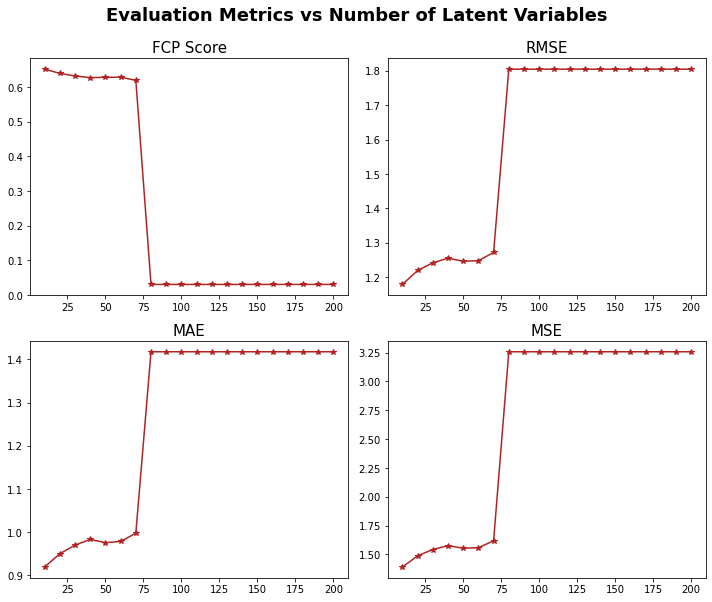

In [42]:
plt.subplots(2,2, figsize=(10,8))
plottables = [FCP_scores, RMSE_scores, MAE_scores, MSE_scores]
plottables_titles = ['FCP Score', 'RMSE', 'MAE', 'MSE']

for i, metric in enumerate(plottables):
    plt.subplot(2,2,i+1)
    plt.plot(N_Factors_list, metric, color='firebrick', marker="*")
    plt.title(f'{plottables_titles[i]}', fontsize=15)

plt.tight_layout()
plt.suptitle('Evaluation Metrics vs Number of Latent Variables', y=1.04, fontsize=18, fontweight=800)
plt.show()

The error terms used are as follows:
- [FCP Score](https://rstudio-pubs-static.s3.amazonaws.com/208557_98ec34a956004fd081aa65e625bdf135.html): Fraction of Concordant Pairs. This metric judges the percentage of predicted ratings pairs that were in the correct order.
- [MAE](https://rstudio-pubs-static.s3.amazonaws.com/208557_98ec34a956004fd081aa65e625bdf135.html): Mean Absolute Error. Summation of the absolute value of the difference between the prediction and the rating, divided by the number of ratings.
- [MSE](https://rstudio-pubs-static.s3.amazonaws.com/208557_98ec34a956004fd081aa65e625bdf135.html): Mean Square Error. Penalizes large errors over small errors, meaning it would be more erroneous to have 1 out of 3 ratings be off by 4 and 2 be off by none than for all 3 ratings to be off by 1.
- RMSE: Root Mean Square Error. The square root of the MSE.

It seems as though all of the error terms flow together and show that there is a significant loss of accuracy past 75 variables. We will then search within the lower ranges and see where the optimal values are for the other hyperparameters.

## 3.2 Grid Search for Hyperparameter Optimization

For the next stages of optimization, we will be running some grid searches. These grid searches allow for quick optimization and will return the best options according to whatever error metrics are specified. The Grid Search also uses cross validation to judge the accuracy, so we have to input a different style of dataset as before. We will be using the surprise dataset function to do so. Even though it is unnecessary, for the sake of meticulousness, we will be doing the grid search on a validation set instead of the whole dataset.

To separate off a random sample of a surprise dataset, the surprise package has a section of [code](https://surprise.readthedocs.io/en/stable/FAQ.html) supplied.

In [6]:
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader=reader)

In [7]:
# help from:
# https://surprise.readthedocs.io/en/stable/FAQ.html

# take out raw ratings from the dataset
raw_ratings = ratings_data.raw_ratings

# shuffle them
random.shuffle(raw_ratings)

# instantiate the index threshold
threshold = int(0.8* len(raw_ratings))

# separate off 80% for the validation and test sets
trainset_raw_ratings = raw_ratings[:threshold]
testset_raw_ratings = raw_ratings[threshold:]

In [8]:
# reconstruct the datasets from the raw ratings
ratings_data.raw_ratings = trainset_raw_ratings
testset_data = ratings_data.construct_testset(testset_raw_ratings)

We are now ready for the grid searches. We will be using RMSE, MAE and FCP as metrics to judge optimal parameter values. The parameters chosen at the moment are the number of factors, the number of epochs and the learning rate.

### 3.2.1 Grid Search 1

In [77]:
%%time

params = {'n_factors': [5,10,25], # starting on the lower end
          'n_epochs': [5,10,15,20], # choosing values around the default
          'lr_all': [0.002,0.005,0.01]} # choosing values around the default

# 3 fold cross validation with the SVD
grid_search = GridSearchCV(SVD, params, measures=['rmse', 'mae', 'fcp'], cv=3, joblib_verbose=2, n_jobs=-2)

grid_search.fit(ratings_data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  4.3min


CPU times: user 1min 26s, sys: 5.58 s, total: 1min 32s
Wall time: 13min 29s


[Parallel(n_jobs=-2)]: Done 108 out of 108 | elapsed: 13.4min finished


In [80]:
grid_search.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.01},
 'mae': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.01},
 'fcp': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.01}}

It looks like for all metrics the ideal parameters are the same. The number of epochs and the learning rate are at the edge of the search, so we will widen it a bit and run it again.

### 3.2.2 Grid Search 2

In [81]:
%%time

params = {'n_factors': [3,4,5,10,25,50], # choosing higher factors for fun
          'n_epochs': [15,20,25,50], # more epochs
          'lr_all': [0.005,0.01,0.02,0.05]} # higher learning rate

grid_search = GridSearchCV(SVD, params, measures=['rmse', 'mae', 'fcp'], cv=3, joblib_verbose=2, n_jobs=-2)

grid_search.fit(ratings_data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed: 24.2min


CPU times: user 3min 42s, sys: 9.64 s, total: 3min 51s
Wall time: 55min 31s


[Parallel(n_jobs=-2)]: Done 288 out of 288 | elapsed: 55.5min finished


In [82]:
grid_search.best_params

{'rmse': {'n_factors': 3, 'n_epochs': 50, 'lr_all': 0.01},
 'mae': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01},
 'fcp': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01}}

The number of epochs is still at the edge of our search so we will go again. However, this round has proven that the learning rate for all is best set at 0.01, so we will no longer be searching different values for this.

### 3.2.3 Grid Search 3

For this round, we have added in the optimization of the [regularization](https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361) term. This will avoid overfitting by adding a penalty to the optimization. 

In [83]:
%%time

params = {'n_factors': [3,4,5],
          'n_epochs': [45,50,55],
          'lr_all': [0.01],
          'reg_all': [0.01,0.02,0.03]}

grid_search = GridSearchCV(SVD, params, measures=['rmse', 'mae', 'fcp'], cv=3, joblib_verbose=2, n_jobs=-2)

grid_search.fit(ratings_data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  8.3min


CPU times: user 1min 5s, sys: 3.66 s, total: 1min 8s
Wall time: 19min 6s


[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed: 19.0min finished


In [84]:
grid_search.best_params

{'rmse': {'n_factors': 3, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.03},
 'mae': {'n_factors': 4, 'n_epochs': 55, 'lr_all': 0.01, 'reg_all': 0.02},
 'fcp': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.03}}

For this round we can see a divergence in the best parameters for the error terms. We now need to decide which error terms to prioritize.<br>
RMSE penalizes large errors in a way that MAE does not. Using RMSE as the choice of error optimization would ensure that you have small errors, but there might be more predicted ratings that have errors than with MAE. But the errors with MAE may be much larger than with RMSE. For movie ratings, it would be permissible if many of the predicted ratings were off by one level, but if you were to make a gross misjudgement in a rating, such as rating something a 5 that was meant to be a 1, then you would recommend something that the user would definitely not like, which is not ideal. However, predicting a rating of 4 when the actual rating is 3 multiple times over, is not as large of an oversight and most likely wouldn't cause as many issues.<br>
The FCP score looks at the fraction of pairs that are in the right "order", testing pairwise accuracy. This measure will be useful for making sure that our prediction rankings are solid.<br>
With all of this in mind, we will attempt to find parameter values that satisfy both the RMSE and FCP scores, within reason. We can see that the regularization is on the edge so we will have to expand that parameter search. The FCP score shows best values at 5 factors while the RMSE shows best values at 3 factors. Three factors is much too low and could possibly lead to the model being underfit, so we will be choosing for the next round to search around 5 factors.

### 3.2.4 Grid Search 4

In [11]:
%%time

params = {'n_factors': [4,5,6],
          'n_epochs': [50,52,55],
          'lr_all': [0.01],
          'reg_all': [0.02,0.04,0.06]}

grid_search = GridSearchCV(SVD, params, measures=['rmse', 'mae', 'fcp'], cv=3, joblib_verbose=2, n_jobs=-2)

grid_search.fit(ratings_data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  9.0min


CPU times: user 1min 7s, sys: 3.28 s, total: 1min 10s
Wall time: 20min 50s


[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed: 20.8min finished


In [12]:
grid_search.best_params

{'rmse': {'n_factors': 6, 'n_epochs': 55, 'lr_all': 0.01, 'reg_all': 0.06},
 'mae': {'n_factors': 5, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.04},
 'fcp': {'n_factors': 6, 'n_epochs': 55, 'lr_all': 0.01, 'reg_all': 0.06}}

Once again, the regularization, number of factors and epochs are all on the edge so we will have to expand further.

### 3.2.5 Grid Search 5

In [13]:
%%time

params = {'n_factors': [5,10,20,50],
          'n_epochs': [50,100,150],
          'lr_all': [0.01],
          'reg_all': [0.01,0.06,0.08,0.1]}

grid_search = GridSearchCV(SVD, params, measures=['rmse', 'mae', 'fcp'], cv=3, joblib_verbose=2, n_jobs=-2)

grid_search.fit(ratings_data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed: 14.5min


CPU times: user 1min 58s, sys: 6.15 s, total: 2min 4s
Wall time: 1h 27min 41s


[Parallel(n_jobs=-2)]: Done 144 out of 144 | elapsed: 87.6min finished


In [14]:
grid_search.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.08},
 'mae': {'n_factors': 5, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.06},
 'fcp': {'n_factors': 50, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.08}}

This last search shows the RMSE and FCP agreeing on values for the hyperparameters. We will now continue on with the number of epochs, learning rate and regularization set at 50, 0.01 and 0.08, respectively. However, to find the optimal number of factors, we will be using a for loop and visualizing the changes in error terms.

## 3.3 Visualization of Scores at Best Parameters

For this stage of optimization, we will again be using the train-test-split data from 3.1.

In [60]:
%%time

FCP_scores = []
RMSE_scores = []
MAE_scores = []
MSE_scores = []

N_Factors_list = [34,38,42,46,48,50,52,54,56,60,64] # searching around 50
    
for num in N_Factors_list:    
    print(f'Fitting #factors = {num}')
    ratings_FunkSVD = SVD(n_factors=num, 
                           n_epochs=50, # number of epochs
                           lr_all=0.01, # learning rate
                           reg_all=0.08, # regularization
                           biased=False, 
                           verbose=0)

    ratings_FunkSVD.fit(ratings_train_dataset)
    predictions = ratings_FunkSVD.test(ratings_test_dataset)
    FCP_scores.append(accuracy.fcp(predictions, verbose=False))
    RMSE_scores.append(accuracy.rmse(predictions, verbose=False))
    MAE_scores.append(accuracy.mae(predictions, verbose=False))
    MSE_scores.append(accuracy.mse(predictions, verbose=False))

Fitting #factors = 34
Fitting #factors = 38
Fitting #factors = 42
Fitting #factors = 46
Fitting #factors = 48
Fitting #factors = 50
Fitting #factors = 52
Fitting #factors = 54
Fitting #factors = 56
Fitting #factors = 60
Fitting #factors = 64
CPU times: user 16min 29s, sys: 16.4 s, total: 16min 46s
Wall time: 19min 23s


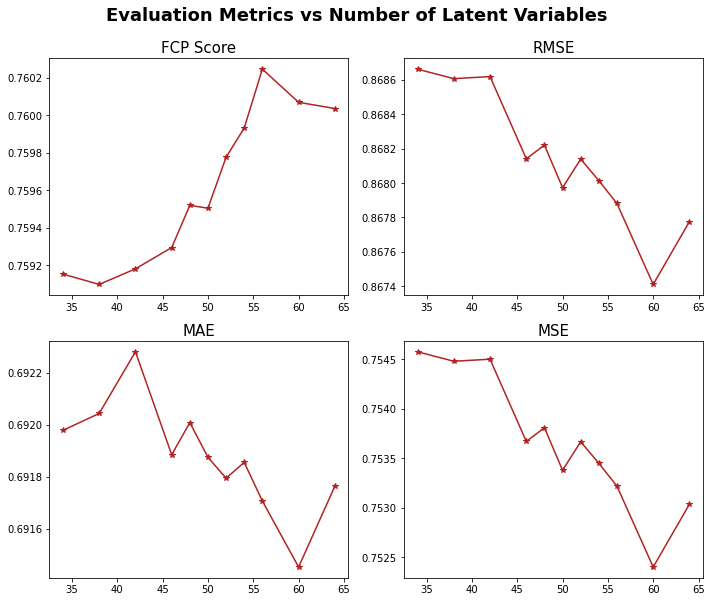

In [86]:
plt.subplots(2,2, figsize=(10,8))
plottables = [FCP_scores, RMSE_scores, MAE_scores, MSE_scores]
plottables_titles = ['FCP Score', 'RMSE', 'MAE', 'MSE']

for i, metric in enumerate(plottables):
    plt.subplot(2,2,i+1)
    plt.plot(N_Factors_list, metric, color='firebrick', marker="*")
    plt.title(f'{plottables_titles[i]}', fontsize=15)

plt.tight_layout()
plt.suptitle('Evaluation Metrics vs Number of Latent Variables', y=1.04, fontsize=18, fontweight=800)
plt.show()

The error terms all move together and show that the best number of latent variables is 60. However, the peak for the FCP score is at 56. Since the difference in score on the error terms from 56 to 60 is much larger than the difference for the FCP score, we will be going with 60 as the number of factors.

## 3.4 Retraining Best SVD on Full Trainset

Now that we have optimized the hyperparameters, we will retrain the model on the full dataset and use the surprise package to build a testset from that. Again, we are not concerned about conventional data leakage for recommender systems because the evaluation metrics are more useful when compared against different iterations of the same model, less so across many different models or datasets.

In [11]:
# building test and train
train_fullset = ratings_utility.build_full_trainset()
test_fullset = train_fullset.build_testset()

In [12]:
# instantiating model
best_svd = SVD(n_factors=60, n_epochs=50, lr_all=0.01, reg_all=0.08, biased=False)

In [13]:
# retraining the best estimator on a full trainset
best_svd.fit(train_fullset)

In [14]:
# checking evaluation metrics based on the test set
SVD_testset_predictions = best_svd.test(test_fullset)
print(f'RMSE: {accuracy.rmse(SVD_testset_predictions)}')
print(f'FCP: {accuracy.fcp(SVD_testset_predictions)}')
print(f'MAE: {accuracy.mae(SVD_testset_predictions)}')
print(f'MSE: {accuracy.mse(SVD_testset_predictions)}')

RMSE: 0.7908
RMSE: 0.7907815295633329
FCP:  0.7983
FCP: 0.7982776594992249
MAE:  0.6304
MAE: 0.63038010591808
MSE: 0.6253
MSE: 0.6253354274985243


We can now create predictions for unknown values using this version of our SVD. To do so, we create something known as the anti-testset. This dataset is all of the unknown values in the original dataset. We can then score the model on these and create a predictions dataset.

In [13]:
# creating anti-testset
ratings_antitest = train_fullset.build_anti_testset()

In [16]:
# creating predictions
%%time
SVD_anti_predictions = best_svd.test(ratings_antitest)

CPU times: user 3min 10s, sys: 2min 49s, total: 5min 59s
Wall time: 6min 40s


Now that we have the model and the predictions, we can save it as a pkl file to use in the next notebook.

In [17]:
# saving model and predictions
%%time
dump.dump('final_svd_test.pkl', predictions=SVD_testset_predictions, algo=best_svd)
dump.dump('final_svd_anti.pkl', predictions=SVD_anti_predictions, algo=best_svd)

CPU times: user 5min 8s, sys: 10min 2s, total: 15min 10s
Wall time: 19min 23s


## 3.5 Visualization of Latent Variables

We can also visualize the latent variables that are stored in the model. The latent variables describe the underlying trends or preferences that influence user behaviour. They are not directly interpretable, since it is a form of dimensionality reduction. However, it is interesting to see if patterns emerge.

In [91]:
# getting user matrix
U = best_svd.pu
U.shape

(6040, 60)

In [92]:
# getting movie matrix
M = best_svd.qi.T
M.shape

(60, 3706)

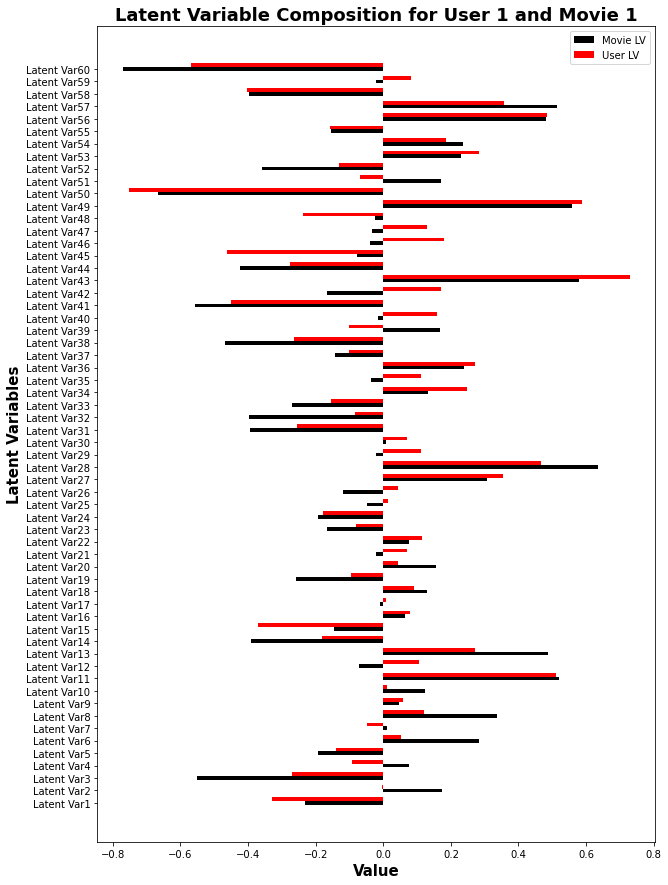

In [93]:
# help from :
# https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged
# to make a side by side bar graph

movie1_latent_variables = M[:,0] # we know this as toy story
user1_latent_variables = U[0,:] # we know their rating as 4

# specifying axis position for each variable
axis_position = np.arange(1,len(movie1_latent_variables)+1)
# specificying bar width
bar_width = 0.3

plt.figure(figsize=(10,15))
plt.barh(axis_position, movie1_latent_variables, bar_width, label='Movie LV', color='black')
# for the second, the axis position is the same as before, plus the bar width, so the bar is directly adjacent
plt.barh(axis_position+bar_width, user1_latent_variables, bar_width, label='User LV', color='red')

plt.ylabel('Latent Variables', fontsize=15, fontweight=800)
plt.xlabel('Value', fontsize=15, fontweight=800)
plt.yticks(axis_position, [f'Latent Var{i}' for i in axis_position])
plt.title('Latent Variable Composition for User 1 and Movie 1', fontsize=18, fontweight=800)

plt.legend()
plt.show()


From a quick search of the dataset, we know that user 1 rated movie 1 (Toy Story) as a 4. You can see that a significant portion of the latent variables seem to match up to one another, or at least trend in the same direction. These latent variables could describe certain trends in the data, such as animated films or movies about toys. We cannot know for sure at this moment.

We can, however, use the profiles of the user and film (made up of the latent variable values) to find the predicted rating for this film by the user.

In [95]:
# user 1 profile
inner_userid_1 = train_fullset.to_inner_uid(1)
user1_profile = U[inner_userid_1]
user1_profile

array([-0.32797276, -0.0044404 , -0.26910334, -0.09379053, -0.13951235,
        0.05125416, -0.04895082,  0.11919003,  0.05958228,  0.01051432,
        0.51075268,  0.10451903,  0.27241758, -0.1800402 , -0.37109039,
        0.07896159,  0.00733823,  0.09095142, -0.09621368,  0.04480028,
        0.06868544,  0.11504747, -0.08183265, -0.17877732,  0.01535705,
        0.04405527,  0.3544595 ,  0.46640911,  0.11095682,  0.07037792,
       -0.25407358, -0.08227748, -0.15547923,  0.24636781,  0.11273688,
        0.27243453, -0.10197258, -0.26381449, -0.10114736,  0.15789815,
       -0.44940105,  0.17192877,  0.729732  , -0.27700023, -0.46311032,
        0.18076977,  0.12978161, -0.23825971,  0.5886186 , -0.75105788,
       -0.0689459 , -0.13143953,  0.283947  ,  0.18425083, -0.15699498,
        0.48569282,  0.35668221, -0.40199612,  0.08297083, -0.5684172 ])

In [96]:
# movie 1 profile
inner_movieid_1 = train_fullset.to_inner_iid(1)
movie1_profile = M[:, inner_movieid_1]
movie1_profile

array([-1.46183991e-01,  1.26207670e-01, -2.65975544e-01,  4.79738076e-03,
       -3.35559800e-01,  8.98344779e-02,  3.76583161e-02,  1.65338519e-01,
        1.87509463e-01,  9.27427705e-02,  6.64972790e-01,  2.76363103e-04,
        3.85149568e-01, -4.79905744e-01, -2.34383293e-01, -2.46978344e-02,
       -4.32703309e-02,  1.62966009e-01, -1.16917680e-01,  9.43364395e-02,
        9.80425381e-02,  1.38787759e-01, -1.42971526e-01, -7.82718380e-02,
       -1.81162098e-01,  7.98029496e-02,  2.10985504e-01,  5.08561332e-01,
        5.97060017e-02,  5.37223399e-02, -3.98095382e-01, -5.16924933e-01,
       -1.09001804e-01,  7.38150136e-02, -2.20380704e-01,  3.26522321e-01,
       -1.69888626e-01, -4.19225230e-01, -7.99723227e-02,  4.40036873e-02,
       -5.26327196e-01,  1.16528675e-01,  6.09418239e-01, -3.04206795e-01,
       -3.39703077e-01,  8.21693694e-02, -1.09013147e-01, -3.23633166e-01,
        3.29469244e-01, -5.02230309e-01,  1.04481704e-01, -1.11295923e-01,
        1.27854680e-01,  

The predicted rating is the dot product of the two profiles.

In [97]:
# calculating dot product
expected_rating_user1movie1 = np.dot(user1_profile, movie1_profile)
expected_rating_user1movie1

4.296903482986218

We know the actual rating is 4 and our model predicted a rating of 4.3.

# 4. KNNBaseline

Of the other model options, the KNNBaseline seemed to be the most intriguing. This model is a KNN style type of recommender, which takes into account a baseline rating for both the user and the item. This means that the model removes some of the skew that can occur when people are generally more or less positive about how they review. It also takes into account the average rating of a film, to be able to judge if a users rating deviates from the norm. Like other KNN models, the model predicts the ratings for a film based on the number of "nearest" neighbours, which are calculated using the pearson correlation coefficient, modified to use item and user baselines instead of population means.

## 4.1 Number of Neighbours Optimization

For the optimization, we will be searching for the optimal number of neighbours, using the defaults for other parameters.

In [152]:
%%time

# evaluation metrics
FCP_scores = []
RMSE_scores = []
MAE_scores = []
MSE_scores = []

# number neighbours
Ks = [40,50,60,70,80,90]

# for loop
for k in Ks:    
    print(f'Fitting k = {k}')
    ratings_KNN = KNNBaseline(k=k, sim_options={'name':'pearson_baseline', 'user_based': True}, bsl_options={'method': 'als'})

    ratings_KNN.fit(ratings_train_dataset)
    predictions = ratings_KNN.test(ratings_test_dataset)
    FCP_scores.append(accuracy.fcp(predictions, verbose=False))
    RMSE_scores.append(accuracy.rmse(predictions, verbose=False))
    MAE_scores.append(accuracy.mae(predictions, verbose=False))
    MSE_scores.append(accuracy.mse(predictions, verbose=False))

Fitting k = 40
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Fitting k = 50
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Fitting k = 60
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Fitting k = 70
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Fitting k = 80
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Fitting k = 90
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
CPU times: user 28min 3s, sys: 19.9 s, total: 28min 23s
Wall time: 30min 13s


## 4.2 Visualization of Scores for Number of Neighbours

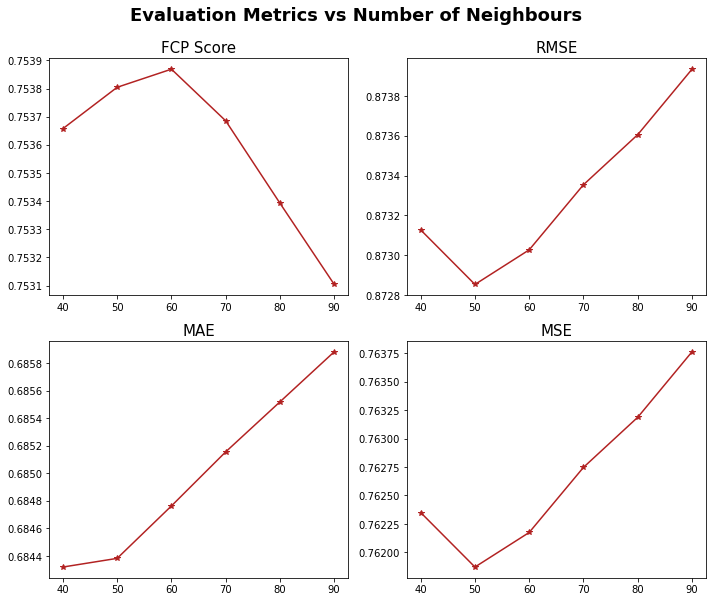

In [153]:
plt.subplots(2,2, figsize=(10,8))
plottables = [FCP_scores, RMSE_scores, MAE_scores, MSE_scores]
plottables_titles = ['FCP Score', 'RMSE', 'MAE', 'MSE']

for i, metric in enumerate(plottables):
    plt.subplot(2,2,i+1)
    plt.plot(Ks, metric, color='firebrick', marker="*")
    plt.title(f'{plottables_titles[i]}', fontsize=15)

plt.tight_layout()
plt.suptitle('Evaluation Metrics vs Number of Neighbours', y=1.04, fontsize=18, fontweight=800)
plt.show()

It seems as though the best value for the number of neighbours is 50 for the error terms and 60 for the FCP score. Again, because the difference in values for the error terms is larger between 50 and 60 than it is for the FCP score, we will be continuing with 50 as our optimal number of neighbours.

## 4.3 Retraining Best KNN on Full Trainset

As with the SVD before, we can retrain the KNN on the full dataset and get predictions for the full anti-testset. We can then save the model and predictions for use later on.

In [12]:
# retraining best estimator on the full set
KNNBest = KNNBaseline(k=50, sim_options={'name':'pearson_baseline', 'user_based': True}, bsl_options={'method': 'als'})
KNNBest.fit(ratings_train_dataset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [16]:
# getting predictions for the smaller testset
KNN_testset_predictions = KNNBest.test(ratings_test_dataset)
print(f'FCP: {accuracy.fcp(KNN_testset_predictions, verbose=False)}')
print(f'RMSE: {accuracy.rmse(KNN_testset_predictions, verbose=False)}')
print(f'MAE: {accuracy.mae(KNN_testset_predictions, verbose=False)}')
print(f'MSE: {accuracy.mse(KNN_testset_predictions, verbose=False)}')

FCP: 0.7521624488045462
RMSE: 0.8749808920945615
MAE: 0.6859648175085409
MSE: 0.7655915615305948


In [14]:
# getting prediction for the anti-testset
%%time
KNN_anti_predictions = KNNBest.test(ratings_antitest)

CPU times: user 1h 19min 22s, sys: 1min 41s, total: 1h 21min 4s
Wall time: 1h 25min 40s


In [19]:
# saving smaller predictions set
%%time
dump.dump('final_KNN_test.pkl', predictions=KNN_testset_predictions, algo=KNNBest)

CPU times: user 3.93 s, sys: 4.33 s, total: 8.26 s
Wall time: 11 s


In [15]:
# saving anti-testset predictions
%%time
dump.dump('final_KNN_anti.pkl', predictions=KNN_anti_predictions, algo=KNNBest)

CPU times: user 3min 17s, sys: 5min 23s, total: 8min 41s
Wall time: 14min 4s


This concludes the model selection and optimization process. Please continue to notebook 3/4 for further evaluation and creation of recommender functions.